In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 1. Read audio

In [2]:
# Đọc tệp âm thanh .wav từ file đã tải lên
file_path = '../data/i.wav'
data, sampling_rate = librosa.load(file_path, sr=None)

In [3]:
# Nếu là âm thanh stereo, chuyển sang mono (chỉ lấy một kênh)
if len(data.shape) == 2:
    data = data.mean(axis=1)

# 2. Remove silent frames

In [4]:
def remove_silent_frames(data: np.ndarray, threshold=0.005, frame_length=30, hop_size=15) -> np.ndarray:
    # Tính RMSE
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_size, center=True)

    # Tạo danh sách các frame mà RMSE >= ngưỡng
    valid_frames = np.where(rmse[0] >= threshold)[0]

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_size)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_size)

    print(f"Start sample index: {start_sample_index}")
    print(f"End sample index: {end_sample_index}")

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return data[start_sample_index:end_sample_index]

In [5]:
signal_segment = remove_silent_frames(data)

Start sample index: 7635
End sample index: 14085


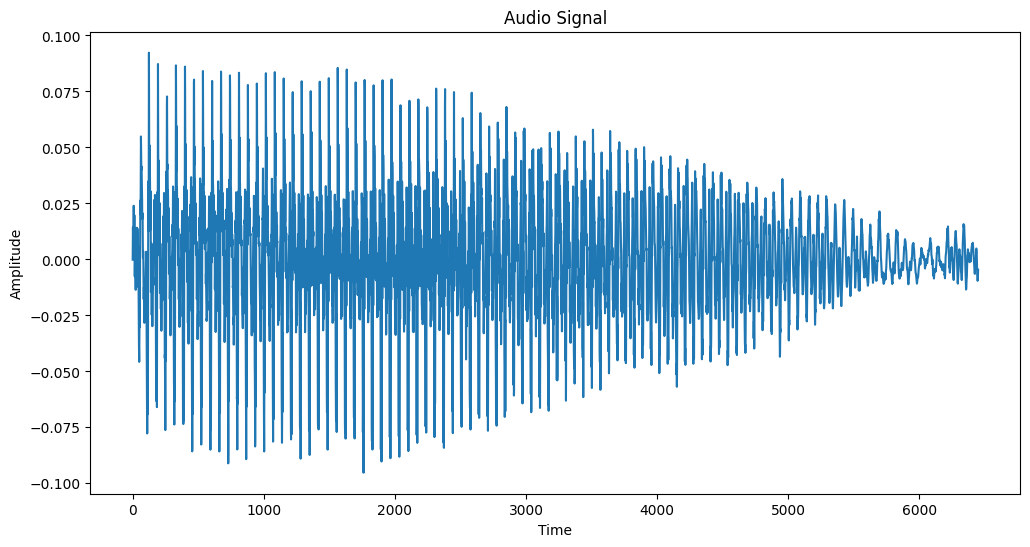

In [6]:
# Plot tín hiệu âm thanh
plt.figure(figsize=(12, 6))
plt.plot(signal_segment)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.show()

# 3. Find F0 using HPS

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

def hps(x: np.ndarray, sampling_rate: int, max_harmonics: int=3):
    """Tìm tần số cơ bản bằng phương pháp Harmonic Product Spectrum (HPS) và vẽ phổ hài."""

    # Tính biến đổi Fourier
    N = len(x)
    T = 1.0 / sampling_rate
    yf = fft(x)
    xf = fftfreq(N, T)[:N//2]
    amplitude_spectrum = 2.0 / N * np.abs(yf[:N//2])

    # Khởi tạo phổ HPS với phổ FFT đầu tiên
    hps_spectrum = amplitude_spectrum.copy()

    # Tạo figure để vẽ
    plt.figure(figsize=(12, max_harmonics * 4))
    
    # Vẽ phổ gốc
    plt.subplot(max_harmonics+1, 1, 1)
    plt.plot(xf, amplitude_spectrum)
    plt.title("Amplitude Spectrum of Original Signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    
    # Nhân phổ với các bội số hài
    for i in range(2, max_harmonics + 1):
        harmonic_spectrum = np.zeros_like(amplitude_spectrum)
        # Chỉ số cho phổ hài
        harmonic_index = np.arange(0, len(amplitude_spectrum))
        # Chỉ số bội số hài
        harmonic_index = harmonic_index * i
        # Giới hạn chỉ số để tránh vượt quá kích thước của phổ
        harmonic_index = harmonic_index[harmonic_index < len(amplitude_spectrum)]
        harmonic_spectrum[harmonic_index.astype(int)] = amplitude_spectrum[harmonic_index.astype(int)]
        
        # Nhân phổ HPS với phổ hài
        hps_spectrum *= harmonic_spectrum
        
        # Vẽ phổ hài
        plt.subplot(max_harmonics+1, 1, i)
        plt.plot(xf, harmonic_spectrum)
        plt.title(f"Harmonic {i} Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")

    # Vẽ phổ HPS cuối cùng
    plt.subplot(max_harmonics+1, 1, max_harmonics + 1)
    plt.plot(xf, hps_spectrum)
    plt.title("HPS Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

    # Tìm tần số có biên độ cao nhất trong phổ HPS
    peak_index = np.argmax(hps_spectrum)
    f0 = xf[peak_index]

    return f0, xf, hps_spectrum


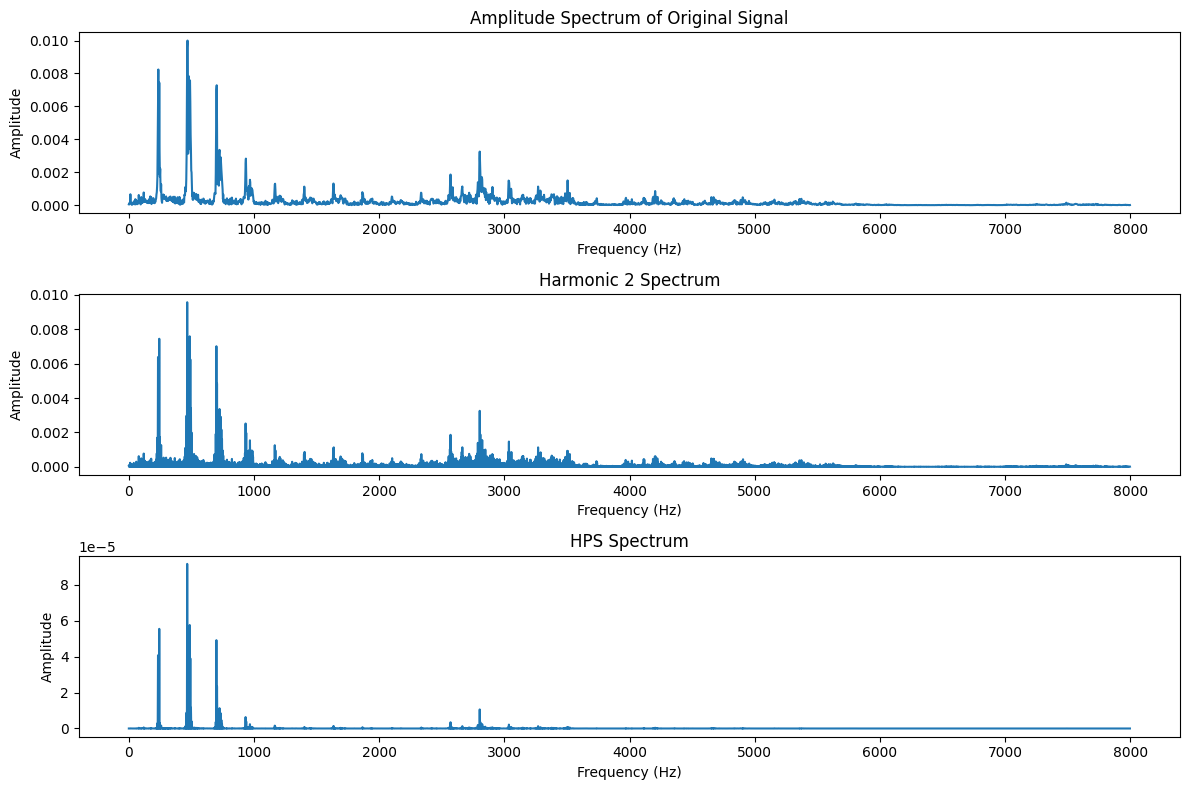

In [8]:
# Tìm tần số cơ bản (F0) bằng phương pháp Harmonic Product Spectrum (HPS)
f0_hps, xf, hps_spectrum = hps(signal_segment, sampling_rate, max_harmonics=2)

In [9]:
# Tìm các chỉ số của top 5 đỉnh cao nhất
top_5_peaks_indices = np.argsort(hps_spectrum)[-5:][::-1]  # Sắp xếp và chọn 5 đỉnh lớn nhất

# Tần số F0 ứng với chỉ số lớn nhất (đỉnh đầu tiên)
f0_top_5 = xf[top_5_peaks_indices]
amplitude_top_5 = hps_spectrum[top_5_peaks_indices]

# In top 5 tần số và biên độ tương ứng
for i, (f0, amplitude) in enumerate(zip(f0_top_5, amplitude_top_5), start=1):
    print(f"Đỉnh {i}: F0 = {f0:.2f} Hz, Biên độ = {amplitude:.4f}")

Đỉnh 1: F0 = 466.36 Hz, Biên độ = 0.0001
Đỉnh 2: F0 = 486.20 Hz, Biên độ = 0.0001
Đỉnh 3: F0 = 471.32 Hz, Biên độ = 0.0001
Đỉnh 4: F0 = 243.10 Hz, Biên độ = 0.0001
Đỉnh 5: F0 = 699.53 Hz, Biên độ = 0.0000


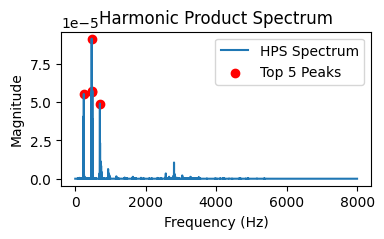

In [10]:
plt.figure(figsize=(4, 2))

# Vẽ phổ HPS
plt.plot(xf, hps_spectrum, label='HPS Spectrum')
plt.scatter(f0_top_5, amplitude_top_5, color='r', label='Top 5 Peaks')  # Đánh dấu top 5 đỉnh
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Harmonic Product Spectrum')
plt.legend()